# Machine Learning Udacity Capstone Project
**"Sentiment analysis in airline tweets"**

Author: Luis Bronchal<br>Date: September 11, 2017

## Machine Learning Models for data codified as Bag of Words

## Summary

We have used the cleaned data obtained during the Exploratory Data Analysis. We have build tools to tokenize the tweets' text and to codify them as Bag of Words. Several machine learning models have been tried on this transformed data and its performance has been compared.

## Data loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import TweetTokenizer
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score

In [2]:
data = pd.read_csv("../output/data_clean.csv")

In [3]:
data.head()

,text,sentiment
0,@VirginAmerica What @dhepburn said.,0
1,@VirginAmerica I didn't today... Must mean I n...,0
2,@VirginAmerica it's really aggressive to blast...,1
3,@VirginAmerica and it's a really big bad thing...,1
4,@VirginAmerica seriously would pay $30 a fligh...,1


In [4]:
train, test = train_test_split(data, test_size=0.2, random_state=1)
X_train = train['text'].values
X_test = test['text'].values
y_train = train['sentiment']
y_test = test['sentiment']

## Bag of Words codification

In [5]:
en_stopwords = set(stopwords.words("english"))  
tknzr = TweetTokenizer()
stemmer = SnowballStemmer('english')
analyzer = CountVectorizer().build_analyzer()

In [6]:
def tokenize(text): 
    tknzr = TweetTokenizer()
    return tknzr.tokenize(text)


def stem(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

vectorizer = CountVectorizer(
    analyzer = 'word',
    tokenizer = tokenize,
    lowercase = True,
    ngram_range=(1, 1),
    stop_words = en_stopwords)

vectorizer_bigram = CountVectorizer(
    analyzer = 'word',
    tokenizer = tokenize,
    lowercase = True,
    ngram_range=(2, 2))

vectorizer_stemmed = CountVectorizer(
    analyzer = stem,
    tokenizer = tokenize,
    lowercase = True,
    ngram_range=(1, 1),
    stop_words = en_stopwords)




In [7]:
parameters_vectorizer = {
    'countvectorizer__max_df': [0.5, 0.9],
    'countvectorizer__min_df': [10, 20, 50],
    'countvectorizer__max_features': [1000, 5000, 10000, None],
    'countvectorizer__ngram_range': ((1, 1), (2, 2))
}    

parameters_vectorizer_2 = {
    'countvectorizer__analyzer': ['word', stem],
    'countvectorizer__stop_words': [en_stopwords, None],
    'countvectorizer__ngram_range': ((1, 1), (2, 2))
}   

In [8]:
def model_generator(X_train, y_train, vectorizer, estimator, estimator_params,
                    kfolds=5, vectorizer_params={}, random_seed=1):

    np.random.seed(random_seed)

    params = {**vectorizer_params, **estimator_params}
    
    pipeline = make_pipeline(vectorizer, estimator)

    grid = GridSearchCV(pipeline,
                    param_grid = params, 
                    cv = kfolds,
                    scoring="roc_auc",
                    verbose=1,   
                    n_jobs=-1) 
    
    grid.fit(X_train, y_train)    
    return grid
    

In [9]:
def report_results(model, X, y, neural_network=False):
    if (neural_network == False):
        pred_proba = model.predict_proba(X)[:, 1]
        pred = model.predict(X)        
    else:
        pred_proba = model.predict(X)
        pred = (pred_proba > 0.5).astype(int)

    auc = roc_auc_score(y, pred_proba)
    acc = accuracy_score(y, pred)
    f1 = f1_score(y, pred)
    prec = precision_score(y, pred)
    rec = recall_score(y, pred)
    result = {'auc': auc, 'f1': f1, 'acc': acc, 'precision': prec, 'recall': rec}
    return result

In [10]:
from sklearn.metrics import roc_curve, auc
    
def get_roc_curve(model, X, y, neural_network=False):
    if (neural_network == False):
        pred_proba = model.predict_proba(X)[:, 1]
    else:
        pred_proba = model.predict(X)

    fpr, tpr, _ = roc_curve(y, pred_proba)

    return fpr, tpr

## Models

### Benchmark model

We are going to use an easy benchmark model. It will choose ramdonly using the same probability seen in the dataset for each class (negative or non-negative).  

In [11]:
np.random.seed(1)

prob_negative = np.sum(y_train==1) / len(y_train)
repetitions = 100
acc_benchmark = [0]*repetitions
auc_benchmark = [0]*repetitions
f1_benchmark = [0]*repetitions
prec_benchmark = [0]*repetitions
rec_benchmark = [0]*repetitions
for i in range(repetitions):
    pred_benchmark = np.random.choice([0, 1], 
                                      len(y_test), 
                                      replace = True, 
                                      p = [1 - prob_negative, prob_negative])
    auc_benchmark[i] = roc_auc_score(y_test, pred_benchmark)
    acc_benchmark[i] = np.sum(pred_benchmark == y_test)/len(y_test)
    f1_benchmark[i] = f1_score(y_test, pred_benchmark)
    prec_benchmark[i] = precision_score(y_test, pred_benchmark)
    rec_benchmark[i] = recall_score(y_test, pred_benchmark)
print("Probability negative sentiment (training set): {:.2f}%".format(prob_negative*100))
print("Accuracy (testing set): {:.6f}".format(np.median(acc_benchmark)))
print("AUC (testing set): {:.6f}".format(np.median(auc_benchmark)))
print("F1 (testing set): {:.6f}".format(np.median(f1_benchmark)))
print("Precission (testing set): {:.6f}".format(np.median(prec_benchmark)))
print("Recall (testing set): {:.6f}".format(np.median(rec_benchmark)))

Probability negative sentiment (training set): 63.82%
Accuracy (testing set): 0.545222
AUC (testing set): 0.499883
F1 (testing set): 0.651528
Precission (testing set): 0.665609
Recall (testing set): 0.637514


If our models performs worst than this benchmark model, we will know we are doing something wrong.

### Quick model

We are going to try first a quick model (Logistic Regression) to see the performance we can have and to estimate the appropiate number of folds to use in cross validation:

In [12]:
np.random.seed(1)

clf = make_pipeline(vectorizer, LogisticRegression(class_weight="balanced"))

folds      = [2, 5, 8, 10, 15, 20]
n_folds    = len(folds)
accuracies = []
stds = []
# Run K-folds
for k in folds:
    cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=1)   
    scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring="roc_auc")
    accuracies.append(scores.mean())
    stds.append(scores.std())
    print("K = {}, auc: {:.4f} (+/- {:0.4f})".format(k, accuracies[-1], 2*stds[-1]))



K = 2, auc: 0.8988 (+/- 0.0081)
K = 5, auc: 0.9070 (+/- 0.0133)
K = 8, auc: 0.9083 (+/- 0.0111)
K = 10, auc: 0.9096 (+/- 0.0177)
K = 15, auc: 0.9098 (+/- 0.0203)
K = 20, auc: 0.9098 (+/- 0.0281)


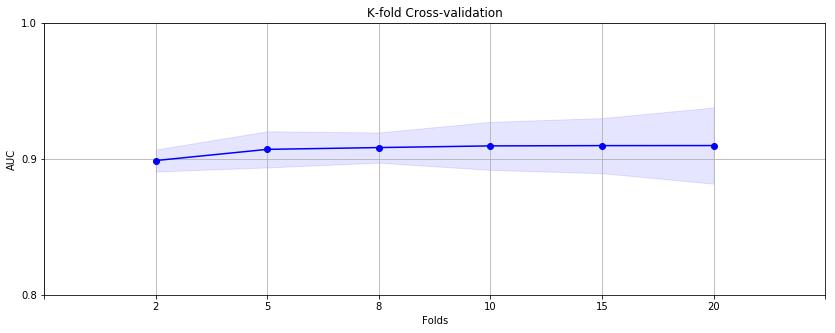

In [13]:
accuracies = np.array(accuracies)
stds = np.array(stds)

train_sizes = range(1, n_folds + 1)

plt.figure(figsize=(14,5))
plt.title("K-fold Cross-validation")

plt.grid()

plt.fill_between(train_sizes, accuracies - 2*stds,
                 accuracies + 2*stds, alpha=0.1, color="b")
    
plt.plot(train_sizes, accuracies, 'o-', color="b", label="Training score")
    
plt.xticks(range(0, n_folds + 2), [''] + [str(k) for k in folds] + [''])
plt.yticks(np.array(range(30, 110, 10))/100)
plt.ylim(0.8, 1.0)

plt.xlabel("Folds")
plt.ylabel("AUC")
plt.savefig('../output/plots/1-number_of_folds.png')
plt.show()

The auc performance is quite plain and it makes sense to choose a kfold for cross validation of 5, which can be a good approximation with less computation requierements. 

The Logistic Regression model without any hyparparameter optimization does it quite well achieving a great cross validation auc performance. It already gets a good auc performance over the testing set:

In [14]:
clf.fit(X_train, y_train)
report_results(clf, X_test, y_test)

{'acc': 0.84145001830831201,
 'auc': 0.91983656196944996,
 'f1': 0.87596677169865367,
 'precision': 0.91392707710699339,
 'recall': 0.84103410341034102}

For the vectorization options we have chosen to transform the raw tweet texts, we are going to have the following number of features:

In [15]:
vectorizer.fit_transform(X_train, y_train).shape

(10920, 13947)

That means *13947* features, and we have only *10920* rows in our training dataset. We are going to check if our model would get better results with more data (it makes sense). For that we are going to obtain its learning curve:

In [16]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = \
    learning_curve(clf, X_train, y_train, cv=5, n_jobs=-1, 
                   scoring="roc_auc", train_sizes=np.linspace(.1, 1.0, 10), random_state=1)

In [17]:
def plot_learning_curve(X, y, train_sizes, train_scores, test_scores, title='', ylim=None, figsize=(14,8)):

    plt.figure(figsize=figsize)
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

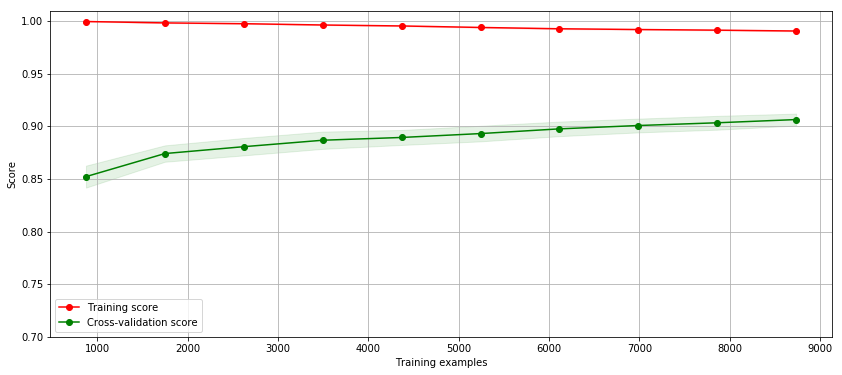

In [18]:
plot_learning_curve(X_train, y_train, train_sizes, 
                    train_scores, test_scores, ylim=(0.7, 1.01), figsize=(14,6))
plt.show()

We can see that with more training data our model gets better cross validation results (auc)

We are going to use the same random folds for all models, so it will be possible to compare performance obtained for each model with the same resampled data. 

In [19]:
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [20]:
all_models = {}

### Logistic Regression

In [21]:
np.random.seed(1)

all_models['lr'] = {}
all_models['lr']['model']  = model_generator(X_train, y_train, vectorizer, 
                                             LogisticRegression(class_weight="balanced"), 
                                             {'logisticregression__C': [.1, 1, 10, 100]}, 
                                             kfolds)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    8.5s finished


In [22]:
all_models['lr']['result'] = report_results(all_models['lr']['model'], X_test, y_test)
all_models['lr']['result']

{'acc': 0.84145001830831201,
 'auc': 0.91983656196944996,
 'f1': 0.87596677169865367,
 'precision': 0.91392707710699339,
 'recall': 0.84103410341034102}

In [23]:
all_models['lr']['model'].best_params_

{'logisticregression__C': 1}

In [24]:
all_models['lr']['roc_curve'] = get_roc_curve(all_models['lr']['model'], X_test, y_test)

In [25]:
all_models['lr']['train_preds'] = all_models['lr']['model'].predict_proba(X_train)[:, 1]

### SVM

In [26]:
np.random.seed(1)

all_models['svm'] = {}
all_models['svm']['model'] = model_generator(X_train, y_train, vectorizer, 
                                    SVC(probability=True, kernel="linear", class_weight="balanced"), 
                                    {'svc__C': [.1, 1, 10]}, 
                                    kfolds)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  2.9min finished


In [27]:
all_models['svm']['result'] = report_results(all_models['svm']['model'], X_test, y_test)
all_models['svm']['result']

{'acc': 0.83632369095569392,
 'auc': 0.92027636498589638,
 'f1': 0.87114442202363784,
 'precision': 0.91520290732889154,
 'recall': 0.83113311331133111}

In [28]:
all_models['svm']['model'].best_params_

{'svc__C': 0.1}

In [29]:
all_models['svm']['roc_curve'] = get_roc_curve(all_models['svm']['model'], X_test, y_test)

In [30]:
all_models['svm']['train_preds'] = all_models['svm']['model'].predict_proba(X_train)[:, 1]

### Naive Bayes

In [31]:
from sklearn.naive_bayes import MultinomialNB

np.random.seed(1)

all_models['nb'] = {}
all_models['nb']['model'] = model_generator(X_train, y_train, vectorizer, 
                                    MultinomialNB(), 
                                    {'multinomialnb__alpha': [.1, 1, 10]}, 
                                    kfolds)



Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    6.9s finished


In [32]:
all_models['nb']['result'] = report_results(all_models['nb']['model'], X_test, y_test)
all_models['nb']['result']

{'acc': 0.84511168070303921,
 'auc': 0.91167369749023108,
 'f1': 0.89049961170075076,
 'precision': 0.84107579462102688,
 'recall': 0.94609460946094615}

In [33]:
all_models['nb']['model'].best_params_

{'multinomialnb__alpha': 1}

In [34]:
all_models['nb']['roc_curve'] = get_roc_curve(all_models['nb']['model'], X_test, y_test)

In [35]:
all_models['nb']['train_preds'] = all_models['nb']['model'].predict_proba(X_train)[:, 1]

### Random Forest

In [36]:
from sklearn.ensemble import RandomForestClassifier

np.random.seed(1)

param_rf = {'randomforestclassifier__n_estimators': [200, 400], 
            'randomforestclassifier__max_features': ['auto', 'sqrt', 'log2']}
    
all_models['rf'] = {}
all_models['rf']['model'] = model_generator(X_train, y_train, vectorizer, 
                                            RandomForestClassifier(class_weight="balanced"),
                                            param_rf, 
                                            kfolds)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.6min finished


In [37]:
all_models['rf']['result'] = report_results(all_models['rf']['model'], X_test, y_test)
all_models['rf']['result']

{'acc': 0.85133650677407546,
 'auc': 0.91499240285474326,
 'f1': 0.891675560298826,
 'precision': 0.86580310880829014,
 'recall': 0.91914191419141911}

In [38]:
all_models['rf']['model'].best_params_

{'randomforestclassifier__max_features': 'log2',
 'randomforestclassifier__n_estimators': 400}

In [39]:
all_models['rf']['roc_curve'] = get_roc_curve(all_models['rf']['model'], X_test, y_test)

In [40]:
all_models['rf']['train_preds'] = all_models['rf']['model'].predict_proba(X_train)[:, 1]

### xgboost

In [41]:
from xgboost import XGBClassifier
from sklearn.base import TransformerMixin 

# Because bug in xgboost: https://github.com/dmlc/xgboost/issues/1238
class CSCTransformer(TransformerMixin):
    def transform(self, X, y=None, **fit_params):
        return X.tocsc()

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}


np.random.seed(1)

all_models['xgb'] = {}

pipeline_xgb = make_pipeline(vectorizer, CSCTransformer(), XGBClassifier())
parameters = {'xgbclassifier__learning_rate': [0.02, 0.05, 0.1], #`eta` value
              'xgbclassifier__min_child_weight': [1, 2],
              'xgbclassifier__max_depth': [6, 10],       
              'xgbclassifier__subsample': [0.5, 0.8, 1],
              'xgbclassifier__colsample_bytree': [0.7, 0.9],
              'xgbclassifier__n_estimators': [100, 500, 1000], #number of trees
}
all_models['xgb']['model'] = GridSearchCV(pipeline_xgb,
                                          param_grid = parameters, 
                                          cv = kfolds,
                                          scoring="roc_auc",
                                          verbose=1,   
                                          n_jobs=-1) 

_ = all_models['xgb']['model'].fit(X_train, y_train)



Fitting 5 folds for each of 216 candidates, totalling 1080 fits


/Users/imac1/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 22.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 42.3min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed: 62.2min finished


In [42]:
all_models['xgb']['result'] = report_results(all_models['xgb']['model'], X_test, y_test)
all_models['xgb']['result']

{'acc': 0.8465763456609301,
 'auc': 0.91397452998311879,
 'f1': 0.88567530695770813,
 'precision': 0.87872225230102874,
 'recall': 0.89273927392739272}

In [43]:
all_models['xgb']['roc_curve'] = get_roc_curve(all_models['xgb']['model'], X_test, y_test)

In [44]:
all_models['xgb']['model'].best_params_

{'xgbclassifier__colsample_bytree': 0.9,
 'xgbclassifier__learning_rate': 0.1,
 'xgbclassifier__max_depth': 6,
 'xgbclassifier__min_child_weight': 1,
 'xgbclassifier__n_estimators': 1000,
 'xgbclassifier__subsample': 1}

In [45]:
all_models['xgb']['train_preds'] = all_models['xgb']['model'].predict_proba(X_train)[:, 1]

### Deep Learning

In [46]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [47]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

In [48]:
def build_nn_model(vocab_len):
    # create model
    model = Sequential()
    model.add(Dense(10, input_dim=vocab_len, kernel_initializer='random_uniform', activation='linear'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])  
    return model  

In [49]:
seed = 1
folds = 5
epochs = 10
cvhistories = []
cvscores = []
cvscores_train = []
i = 0

early_stopping = EarlyStopping(monitor='val_loss', patience=1, verbose=0)

for train_cv, test_cv in kfolds.split(X_train, y_train.values):
    tmp_vec = vectorizer.fit(X_train[train_cv])
    train_cv_dense = tmp_vec.transform(X_train[train_cv]).toarray() 
    test_cv_dense = tmp_vec.transform(X_train[test_cv]).toarray() 
     
    model_nn_cv = build_nn_model(len(tmp_vec.vocabulary_.keys()))

    cvhistory = model_nn_cv.fit(train_cv_dense, 
                                y_train.values[train_cv], 
                                validation_data=(test_cv_dense, y_train.values[test_cv]),  
                                callbacks=[early_stopping], 
                                class_weight=class_weight,
                                epochs=epochs, batch_size=100, verbose=0)
    
    preds_cv = model_nn_cv.predict_proba(test_cv_dense, verbose=0).flatten()
    scores_cv = roc_auc_score(y_train.values[test_cv], preds_cv)
    cvscores.append(scores_cv)

    preds_train_cv = model_nn_cv.predict_proba(train_cv_dense, verbose=0).flatten()
    scores_train_cv = roc_auc_score(y_train.values[train_cv], preds_train_cv)
    cvscores_train.append(scores_train_cv)    
    
    #print("%s: %.2f%%" % ("auc", scores_cv))
    
    print("Fold {:d} ==> Training accuracy: {:0.4f} / Validation accuracy: {:0.4f}". \
          format(i, 100*cvhistory.history['acc'][-1], 100*cvhistory.history['val_acc'][-1])) 
    
    cvhistories.append(cvhistory)
    i+=1

Fold 0 ==> Training accuracy: 92.1351 / Validation accuracy: 85.4005
Fold 1 ==> Training accuracy: 92.0902 / Validation accuracy: 85.4396
Fold 2 ==> Training accuracy: 91.9299 / Validation accuracy: 85.6685
Fold 3 ==> Training accuracy: 91.5293 / Validation accuracy: 83.8370
Fold 4 ==> Training accuracy: 91.7592 / Validation accuracy: 84.4709


In [50]:
print("Training auc: {:0.4f} (+/- {:0.4f})".format(np.mean(cvscores_train), np.std(cvscores_train)))
print("Validation auc: {:0.4f} (+/- {:0.4f})".format(np.mean(cvscores), np.std(cvscores)))

Training auc: 0.9760 (+/- 0.0011)
Validation auc: 0.9158 (+/- 0.0055)


It looks like an interesting cross validation auc. Let's build the model then over all training data to check over the test data:

In [51]:
np.random.seed(1)

vec = vectorizer.fit(X_train)
X_train_dense = vec.transform(X_train).toarray() 
X_test_dense = vec.transform(X_test).toarray() 

model_nn = build_nn_model(len(vec.vocabulary_.keys()))

# class_weight: class 0 =>  8787/4864
history = model_nn.fit(X_train_dense, y_train, validation_split=0.2, 
                       class_weight=class_weight,
                       epochs=20, batch_size=100, callbacks=[early_stopping], verbose=1)

Train on 8736 samples, validate on 2184 samples
Epoch 1/20
8736/8736 [==============================] - 2s - loss: 0.5601 - acc: 0.7071 - val_loss: 0.5035 - val_acc: 0.7582
Epoch 2/20
8736/8736 [==============================] - 1s - loss: 0.4351 - acc: 0.8138 - val_loss: 0.4260 - val_acc: 0.8187
Epoch 3/20
8736/8736 [==============================] - 1s - loss: 0.3642 - acc: 0.8529 - val_loss: 0.3848 - val_acc: 0.8315
Epoch 4/20
8736/8736 [==============================] - 1s - loss: 0.3174 - acc: 0.8760 - val_loss: 0.3599 - val_acc: 0.8370
Epoch 5/20
8736/8736 [==============================] - 1s - loss: 0.2847 - acc: 0.8889 - val_loss: 0.3465 - val_acc: 0.8462
Epoch 6/20
8736/8736 [==============================] - 1s - loss: 0.2601 - acc: 0.9003 - val_loss: 0.3432 - val_acc: 0.8452
Epoch 7/20
8736/8736 [==============================] - 1s - loss: 0.2398 - acc: 0.9089 - val_loss: 0.3392 - val_acc: 0.8475
Epoch 8/20
8736/8736 [==============================] - 1s - loss: 0.2230 - a

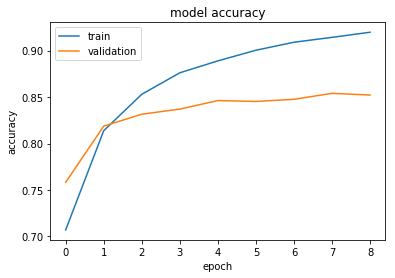

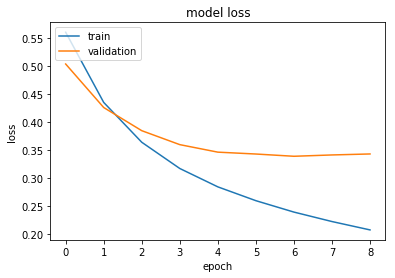

In [52]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [53]:
print("Training accuracy: %.2f%% / Validation accuracy: %.2f%%" % 
      (100*history.history['acc'][-1], 100*history.history['val_acc'][-1]))

Training accuracy: 91.96% / Validation accuracy: 85.21%


In [54]:
all_models['nn'] = {}
all_models['nn']['model'] = model_nn
all_models['nn']['result'] = report_results(all_models['nn']['model'], X_test_dense, y_test, neural_network=True)
all_models['nn']['roc_curve'] = get_roc_curve(all_models['nn']['model'], X_test_dense, y_test, neural_network=True)
all_models['nn']['result']

{'acc': 0.85792749908458443,
 'auc': 0.922016900485229,
 'f1': 0.89299503585217865,
 'precision': 0.89546460176991149,
 'recall': 0.89053905390539057}

In [55]:
all_models['nn']['train_preds'] = all_models['nn']['model'].predict(X_train_dense).flatten()

## Bag of words with Tf-Idf

Now we are going to codify input data as bag of words but instead of the number of times a vocabulary token appears, we are going to apply the [tfidf](https://es.wikipedia.org/wiki/Tf-idf) function.

## Models

### Logistic Regression

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_tfidf = TfidfVectorizer(
    analyzer = 'word',
    tokenizer = tokenize,
    lowercase = True,
    ngram_range=(1, 1),
    stop_words = en_stopwords)

In [57]:
np.random.seed(1)

all_models['lr_tfidf'] = {}
all_models['lr_tfidf']['model']  = model_generator(X_train, y_train, vectorizer_tfidf, 
                                             LogisticRegression(class_weight="balanced"), 
                                             {'logisticregression__C': [.1, 1, 10, 100]}, 
                                             kfolds)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    8.2s finished


In [58]:
all_models['lr_tfidf']['result'] = report_results(all_models['lr_tfidf']['model'], X_test, y_test)
all_models['lr_tfidf']['result']

{'acc': 0.84291468326620289,
 'auc': 0.91694410404895921,
 'f1': 0.87959584619702502,
 'precision': 0.89799426934097426,
 'recall': 0.86193619361936191}

In [59]:
all_models['lr_tfidf']['roc_curve'] = get_roc_curve(all_models['lr']['model'], X_test, y_test)

In [60]:
all_models['lr_tfidf']['model'].best_params_

{'logisticregression__C': 10}

In [61]:
all_models['lr_tfidf']['train_preds'] = all_models['lr_tfidf']['model'].predict_proba(X_train)[:, 1]

### SVM

In [62]:
np.random.seed(1)

all_models['svm_tfidf'] = {}
all_models['svm_tfidf']['model'] = model_generator(X_train, y_train, vectorizer_tfidf, 
                                    SVC(probability=True, kernel="linear", class_weight="balanced"), 
                                    {'svc__C': [.1, 1, 10]}, 
                                    kfolds)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  3.3min finished


In [63]:
all_models['svm_tfidf']['result'] = report_results(all_models['svm_tfidf']['model'], X_test, y_test)
all_models['svm_tfidf']['result']

{'acc': 0.84511168070303921,
 'auc': 0.91863644195744887,
 'f1': 0.88121314237573711,
 'precision': 0.90017211703958688,
 'recall': 0.86303630363036299}

In [64]:
all_models['svm_tfidf']['roc_curve'] = get_roc_curve(all_models['svm_tfidf']['model'], X_test, y_test)

In [65]:
all_models['svm_tfidf']['model'].best_params_

{'svc__C': 1}

In [66]:
all_models['svm_tfidf']['train_preds'] = all_models['svm_tfidf']['model'].predict_proba(X_train)[:, 1]

### Naive Bayes

In [67]:
from sklearn.naive_bayes import MultinomialNB

np.random.seed(1)

all_models['nb_tfidf'] = {}
all_models['nb_tfidf']['model'] = model_generator(X_train, y_train, vectorizer_tfidf, 
                                    MultinomialNB(), 
                                    {'multinomialnb__alpha': [.1, 1, 10]}, 
                                    kfolds)



Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    6.3s finished


In [68]:
all_models['nb_tfidf']['result'] = report_results(all_models['nb_tfidf']['model'], X_test, y_test)
all_models['nb_tfidf']['result']

{'acc': 0.80629805931893084,
 'auc': 0.91033259952501266,
 'f1': 0.87181972377029315,
 'precision': 0.77912516240796881,
 'recall': 0.98954895489548955}

In [69]:
all_models['nb_tfidf']['model'].best_params_

{'multinomialnb__alpha': 1}

In [70]:
all_models['nb_tfidf']['roc_curve'] = get_roc_curve(all_models['nb_tfidf']['model'], X_test, y_test)

In [71]:
all_models['nb_tfidf']['train_preds'] = all_models['nb_tfidf']['model'].predict_proba(X_train)[:, 1]

### Random Forest

In [72]:
from sklearn.ensemble import RandomForestClassifier

np.random.seed(1)

param_rf = {'randomforestclassifier__n_estimators': [200, 400], 
            'randomforestclassifier__max_features': ['auto', 'sqrt', 'log2']}
    
all_models['rf_tfidf'] = {}
all_models['rf_tfidf']['model'] = model_generator(X_train, y_train, vectorizer_tfidf, 
                                            RandomForestClassifier(class_weight="balanced"),
                                            param_rf, 
                                            kfolds)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.1min finished


In [73]:
all_models['rf_tfidf']['result'] = report_results(all_models['rf_tfidf']['model'], X_test, y_test)
all_models['rf_tfidf']['result']

{'acc': 0.84913950933723914,
 'auc': 0.91277290379640375,
 'f1': 0.89180672268907557,
 'precision': 0.85326633165829147,
 'recall': 0.93399339933993397}

In [74]:
all_models['rf_tfidf']['model'].best_params_

{'randomforestclassifier__max_features': 'log2',
 'randomforestclassifier__n_estimators': 400}

In [75]:
all_models['rf_tfidf']['roc_curve'] = get_roc_curve(all_models['rf_tfidf']['model'], X_test, y_test)

In [76]:
all_models['rf_tfidf']['train_preds'] = all_models['rf_tfidf']['model'].predict_proba(X_train)[:, 1]

### xgboost

In [77]:
np.random.seed(1)

all_models['xgb_tfidf'] = {}

pipeline_tfidf_xgb = make_pipeline(vectorizer_tfidf, CSCTransformer(), XGBClassifier())
parameters = {'xgbclassifier__learning_rate': [0.02, 0.05, 0.1], #`eta` value
              'xgbclassifier__min_child_weight': [1, 2],
              'xgbclassifier__max_depth': [6, 10],       
              'xgbclassifier__subsample': [0.5, 0.8, 1],
              'xgbclassifier__colsample_bytree': [0.7, 0.9],
              'xgbclassifier__n_estimators': [100, 500, 1000], #number of trees
}
all_models['xgb_tfidf']['model'] = GridSearchCV(pipeline_tfidf_xgb,
                                                param_grid = parameters, 
                                                cv = kfolds,
                                                scoring="roc_auc",
                                                verbose=1,   
                                                n_jobs=-1) 



all_models['xgb_tfidf']['model'].fit(X_train, y_train)



Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 30.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 58.6min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed: 83.8min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_i...logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'xgbclassifier__colsample_bytree': [0.7, 0.9], 'xgbclassifier__max_depth': [6, 10], 'xgbclassifier__learning_rate': [0.02, 0.05, 0.1], 'xgbclassifier__subsample': [0.5, 0.8, 1], 'xgbclassifier__min_child_weight': [1, 2], 'xgbclassifier__n_estimators': [100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

In [78]:
all_models['xgb_tfidf']['result'] = report_results(all_models['xgb_tfidf']['model'], X_test, y_test)
all_models['xgb_tfidf']['result']

{'acc': 0.84218235078725745,
 'auc': 0.90765703076331727,
 'f1': 0.88310279359913213,
 'precision': 0.87105403959336547,
 'recall': 0.89548954895489552}

In [79]:
all_models['xgb_tfidf']['roc_curve'] = get_roc_curve(all_models['xgb_tfidf']['model'], X_test, y_test)

In [80]:
all_models['xgb_tfidf']['model'].best_params_

{'xgbclassifier__colsample_bytree': 0.7,
 'xgbclassifier__learning_rate': 0.1,
 'xgbclassifier__max_depth': 6,
 'xgbclassifier__min_child_weight': 1,
 'xgbclassifier__n_estimators': 1000,
 'xgbclassifier__subsample': 1}

In [81]:
all_models['xgb_tfidf']['train_preds'] = all_models['xgb_tfidf']['model'].predict_proba(X_train)[:, 1]

### Deep Learning

In [82]:
np.random.seed(1)

vec = vectorizer_tfidf.fit(X_train)
X_train_dense = vec.transform(X_train).toarray() 
X_test_dense = vec.transform(X_test).toarray() 

model_nn_tfidf = build_nn_model(len(vec.vocabulary_.keys()))

history = model_nn_tfidf.fit(X_train_dense, y_train, validation_split=0.2, 
                       class_weight=class_weight,
                       epochs=100, batch_size=100, callbacks=[early_stopping], verbose=1)

Train on 8736 samples, validate on 2184 samples
Epoch 1/100
8736/8736 [==============================] - 2s - loss: 0.6361 - acc: 0.6407 - val_loss: 0.6058 - val_acc: 0.6328
Epoch 2/100
8736/8736 [==============================] - 1s - loss: 0.5627 - acc: 0.6708 - val_loss: 0.5520 - val_acc: 0.6923
Epoch 3/100
8736/8736 [==============================] - 1s - loss: 0.4982 - acc: 0.7596 - val_loss: 0.4981 - val_acc: 0.7610
Epoch 4/100
8736/8736 [==============================] - 1s - loss: 0.4385 - acc: 0.8268 - val_loss: 0.4522 - val_acc: 0.8017
Epoch 5/100
8736/8736 [==============================] - 1s - loss: 0.3890 - acc: 0.8585 - val_loss: 0.4174 - val_acc: 0.8233
Epoch 6/100
8736/8736 [==============================] - 1s - loss: 0.3501 - acc: 0.8757 - val_loss: 0.3925 - val_acc: 0.8260
Epoch 7/100
8736/8736 [==============================] - 1s - loss: 0.3193 - acc: 0.8847 - val_loss: 0.3732 - val_acc: 0.8375
Epoch 8/100
8736/8736 [==============================] - 1s - loss: 0.

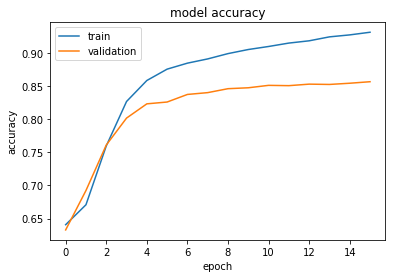

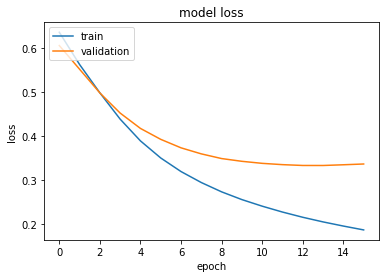

In [83]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [84]:
print("Training accuracy: %.2f%% / Validation accuracy: %.2f%%" % 
      (100*history.history['acc'][-1], 100*history.history['val_acc'][-1]))

Training accuracy: 93.14% / Validation accuracy: 85.67%


In [85]:
all_models['nn_tfidf'] = {}
all_models['nn_tfidf']['model'] = model_nn_tfidf
all_models['nn_tfidf']['result'] = report_results(all_models['nn_tfidf']['model'], 
                                                  X_test_dense, y_test, neural_network=True)
all_models['nn_tfidf']['roc_curve'] = get_roc_curve(all_models['nn_tfidf']['model'], 
                                                    X_test_dense, y_test, neural_network=True)
all_models['nn_tfidf']['result']

{'acc': 0.86232149395825708,
 'auc': 0.9227784224205553,
 'f1': 0.89771490750816108,
 'precision': 0.88805166846071049,
 'recall': 0.90759075907590758}

In [86]:
all_models['nn_tfidf']['train_preds'] = all_models['nn_tfidf']['model'].predict(X_train_dense).flatten()

### SVM better

We decided to try another model: a SVM model exploring a bigger range of hyperparamenter combinations expecially those related with the data codification process. It have taken a lot of time to train, but it has achieved the best results:

In [87]:
parameters_vectorizer = {
    'countvectorizer__analyzer': ['word', stem],    
    'countvectorizer__max_df': [0.5, 0.9],
    'countvectorizer__min_df': [10, 20, 50],
    'countvectorizer__max_features': [1000, 5000, 10000, None],
    'countvectorizer__ngram_range': ((1, 1), (2, 2))
}    



In [88]:
np.random.seed(1)

bb_model = model_generator(X_train, y_train, vectorizer, 
                                    SVC(probability=True, kernel="linear", class_weight="balanced"), 
                                    {'svc__C': [.1, 1, 10, 20]}, 
                                    kfolds, parameters_vectorizer, random_seed=1)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 58.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 125.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 231.6min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 477.1min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 871.5min
[Parallel(n_jobs=-1)]: Done 1920 out of 1920 | elapsed: 966.6min finished


In [89]:
bb_res = report_results(bb_model, X_test, y_test)
bb_res

{'acc': 0.84181618454778473,
 'auc': 0.92523529461379872,
 'f1': 0.87470997679814388,
 'precision': 0.92515337423312882,
 'recall': 0.82948294829482949}

In [90]:
bb_model.best_params_

{'countvectorizer__analyzer': <function __main__.stem>,
 'countvectorizer__max_df': 0.5,
 'countvectorizer__max_features': 5000,
 'countvectorizer__min_df': 10,
 'countvectorizer__ngram_range': (1, 1),
 'svc__C': 0.1}

In [91]:
bb_model.best_score_

0.91674856732185017

In [92]:
all_models['svm_best'] = {}
all_models['svm_best']['model'] = bb_model
all_models['svm_best']['result'] = report_results(all_models['svm_best']['model'], X_test, y_test)
all_models['svm_best']['roc_curve'] = get_roc_curve(all_models['svm_best']['model'], X_test, y_test)
all_models['svm_best']['result']

{'acc': 0.84181618454778473,
 'auc': 0.92523529461379872,
 'f1': 0.87470997679814388,
 'precision': 0.92515337423312882,
 'recall': 0.82948294829482949}

In [93]:
all_models['svm_best']['train_preds'] = all_models['svm_best']['model'].predict(X_train).flatten()

# Models comparison

In [94]:
all_models_name = all_models.keys()

tmp_list = []
for mo in all_models_name:
    tmp_list.append(all_models[mo]['result'])
models_results = pd.DataFrame(dict(zip(all_models_name, tmp_list))).transpose()    

In [95]:
models_results = models_results.sort_values(['auc'], ascending=False)
models_results

,acc,auc,f1,precision,recall
svm_best,0.841816,0.925235,0.874710,0.925153,0.829483
nn_tfidf,0.862321,0.922778,0.897715,0.888052,0.907591
nn,0.857927,0.922017,0.892995,0.895465,0.890539
svm,0.836324,0.920276,0.871144,0.915203,0.831133
lr,0.841450,0.919837,0.875967,0.913927,0.841034
svm_tfidf,0.845112,0.918636,0.881213,0.900172,0.863036
lr_tfidf,0.842915,0.916944,0.879596,0.897994,0.861936
rf,0.851337,0.914992,0.891676,0.865803,0.919142
xgb,0.846576,0.913975,0.885675,0.878722,0.892739
rf_tfidf,0.849140,0.912773,0.891807,0.853266,0.933993


Let's see the roc curves:

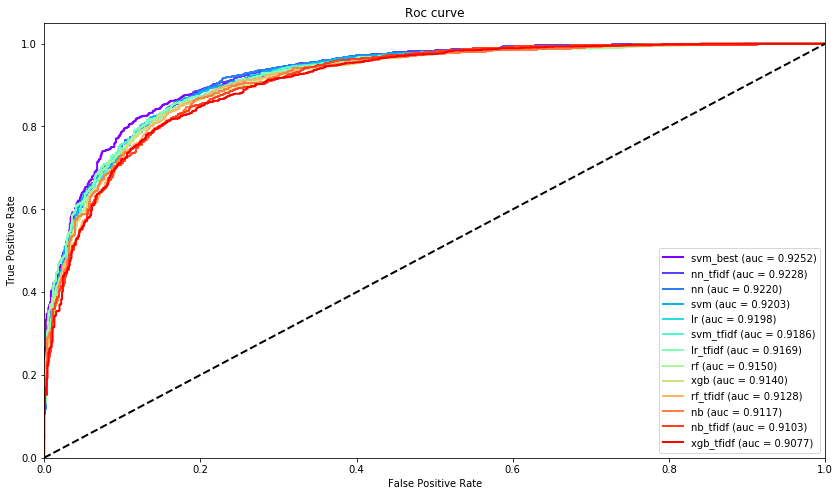

In [96]:
from matplotlib import cm

tmp_models = models_results.index

colors = cm.rainbow(np.linspace(0.0, 1.0, len(tmp_models)))


plt.figure(figsize=(14,8))
lw = 2

for mo, color in zip(tmp_models, colors):
    fpr, tpr = all_models[mo]['roc_curve']
    plt.plot(fpr, tpr, color=color,
         lw=lw, label='{} (auc = {:.4f})'.format(mo, all_models[mo]['result']['auc']))



plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc curve')
plt.legend(loc="lower right")

plt.savefig('../output/plots/roc-curves.png')

plt.show()



Let's see correlation between models:

In [97]:
corr_dict = {}
for mo in tmp_models:
    corr_dict[mo] = all_models[mo]['train_preds'] 

In [98]:
kdata_proba = pd.DataFrame(corr_dict)

In [99]:
corr = kdata_proba.corr()
corr

,lr,lr_tfidf,nb,nb_tfidf,nn,nn_tfidf,rf,rf_tfidf,svm,svm_best,svm_tfidf,xgb,xgb_tfidf
lr,1.000000,0.986964,0.906744,0.900434,0.965678,0.960437,0.936353,0.935927,0.981921,0.846939,0.978194,0.958241,0.955210
lr_tfidf,0.986964,1.000000,0.903586,0.899943,0.949749,0.958187,0.959104,0.958716,0.960728,0.828689,0.984664,0.943737,0.950610
nb,0.906744,0.903586,1.000000,0.943348,0.912866,0.926041,0.870252,0.870145,0.915914,0.775821,0.917092,0.887583,0.875540
nb_tfidf,0.900434,0.899943,0.943348,1.000000,0.906366,0.920275,0.865592,0.866130,0.906185,0.767160,0.905145,0.893243,0.877291
nn,0.965678,0.949749,0.912866,0.906366,1.000000,0.990949,0.896354,0.896487,0.965499,0.833690,0.957433,0.936050,0.927009
nn_tfidf,0.960437,0.958187,0.926041,0.920275,0.990949,1.000000,0.906673,0.906601,0.958978,0.827583,0.966417,0.932099,0.925736
rf,0.936353,0.959104,0.870252,0.865592,0.896354,0.906673,1.000000,0.997824,0.902825,0.788354,0.932578,0.916783,0.945820
rf_tfidf,0.935927,0.958716,0.870145,0.866130,0.896487,0.906601,0.997824,1.000000,0.902210,0.787138,0.932226,0.915336,0.946571
svm,0.981921,0.960728,0.915914,0.906185,0.965499,0.958978,0.902825,0.902210,1.000000,0.852699,0.977612,0.954040,0.942737
svm_best,0.846939,0.828689,0.775821,0.767160,0.833690,0.827583,0.788354,0.787138,0.852699,1.000000,0.838003,0.825854,0.821058


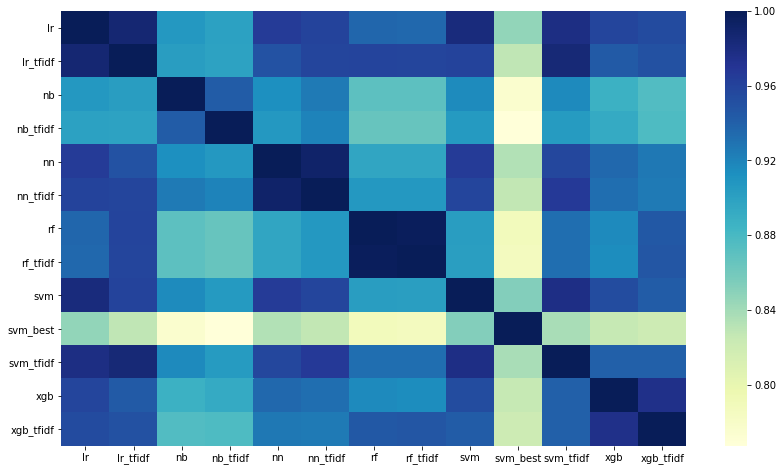

In [100]:
plt.figure(figsize=(14,8))
sns.heatmap(corr, cmap="YlGnBu")
plt.show()

# Stacked model

In [101]:
np.random.seed(1)

from mlxtend.classifier import StackingClassifier

lr_stack = LogisticRegression()


clf_stack = StackingClassifier(classifiers = [all_models['svm_best']['model'].best_estimator_,
                                              all_models['nb_tfidf']['model'].best_estimator_],
                               use_probas = True, 
                               average_probas = False,    
                               meta_classifier = lr_stack,
                               verbose=1)


In [102]:
from sklearn.model_selection import cross_val_score

scores_stack = cross_val_score(clf_stack, X_train, y_train, 
                                               cv=kfolds, scoring='roc_auc')



Fitting 2 classifiers...
Fitting classifier1: pipeline (1/2)
Fitting classifier2: pipeline (2/2)
Fitting 2 classifiers...
Fitting classifier1: pipeline (1/2)
Fitting classifier2: pipeline (2/2)
Fitting 2 classifiers...
Fitting classifier1: pipeline (1/2)
Fitting classifier2: pipeline (2/2)
Fitting 2 classifiers...
Fitting classifier1: pipeline (1/2)
Fitting classifier2: pipeline (2/2)
Fitting 2 classifiers...
Fitting classifier1: pipeline (1/2)
Fitting classifier2: pipeline (2/2)


In [103]:
print("validation auc: {:0.4f} (+/- {:0.4f})".format(np.mean(scores_stack), np.std(scores_stack)))

validation auc: 0.9249 (+/- 0.0049)


In [104]:
clf_stack.fit(X_train, y_train)
report_results(clf_stack, X_test, y_test)

Fitting 2 classifiers...
Fitting classifier1: pipeline (1/2)
Fitting classifier2: pipeline (2/2)


{'acc': 0.87294031490296597,
 'auc': 0.93153471973703383,
 'f1': 0.90684563758389269,
 'precision': 0.8856843209229156,
 'recall': 0.92904290429042902}

In [105]:
train_sizes, train_scores, test_scores = \
    learning_curve(clf_stack, X_train, y_train, cv=5, n_jobs=-1, 
                   scoring="roc_auc", train_sizes=np.linspace(.1, 1.0, 10), random_state=1)
    
  

Fitting 2 classifiers...
Fitting classifier1: pipeline (1/2)
Fitting 2 classifiers...
Fitting classifier1: pipeline (1/2)
Fitting 2 classifiers...
Fitting classifier1: pipeline (1/2)
Fitting 2 classifiers...
Fitting classifier1: pipeline (1/2)
Fitting classifier2: pipeline (2/2)
Fitting classifier2: pipeline (2/2)
Fitting 2 classifiers...
Fitting classifier1: pipeline (1/2)
Fitting classifier2: pipeline (2/2)
Fitting 2 classifiers...
Fitting classifier1: pipeline (1/2)
Fitting classifier2: pipeline (2/2)
Fitting 2 classifiers...
Fitting classifier1: pipeline (1/2)
Fitting classifier2: pipeline (2/2)
Fitting 2 classifiers...
Fitting classifier1: pipeline (1/2)
Fitting classifier2: pipeline (2/2)
Fitting 2 classifiers...
Fitting classifier1: pipeline (1/2)
Fitting classifier2: pipeline (2/2)
Fitting 2 classifiers...
Fitting classifier1: pipeline (1/2)
Fitting classifier2: pipeline (2/2)
Fitting 2 classifiers...
Fitting classifier1: pipeline (1/2)
Fitting classifier2: pipeline (2/2)
Fitti

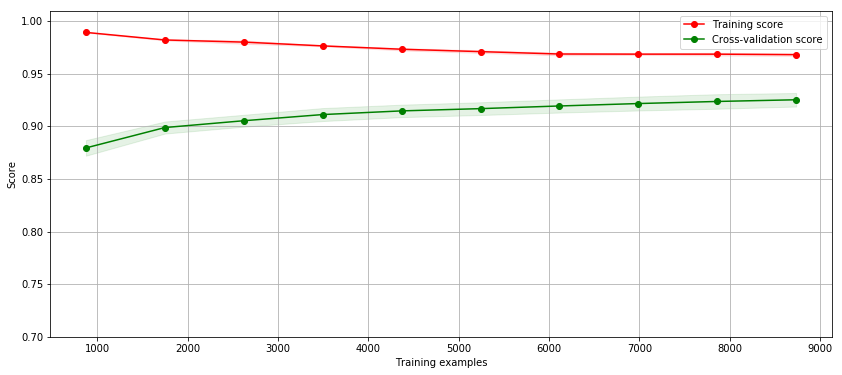

In [106]:
plot_learning_curve(X_train, y_train, train_sizes, 
                    train_scores, test_scores, ylim=(0.7, 1.01), figsize=(14,6))
plt.show()  

The stacked model is the best one, but one downside is than it is a bit slow compared with simpler models:

In [107]:
import time
def get_time_performance(model, X_data):
    """Return the average number of predictions per second of the model using X_data 
    
    Args:
        model: machine learning model
        X_data: data compatible with the model to do predictions on.

    Returns:
        float: Average number of predictions per second   
    """
    
    startTime = time.time()
    _ = model.predict(X_data)
    endTime = time.time()
    result = (len(X_data)) / (endTime - startTime)
    return result

In [108]:
print("Predictions per second: {:.2f}".format(get_time_performance(clf_stack, X_train)))

Predictions per second: 1230.65


In [109]:
print("Predictions per second: {:.2f}".format(get_time_performance(all_models['lr']['model'], X_train)))

Predictions per second: 13294.81


In [110]:
(13503.44 / 1220.15)*100

1106.7032741875998

Let's see some predictions examples from our final model, the stacking model:

In [111]:
clf_stack.predict(["@united very bad experience!"])

array([1])

In [112]:
clf_stack.predict(["@united nice fly. Thanks"])

array([0])

In [113]:
clf_stack.predict(["@united I hate you. I will never fly again with this company!"])

array([1])

In [114]:
clf_stack.predict(["flying with @united is always a great experience"])

array([0])

In [115]:
clf_stack.predict(["flying with @united is always a great experience. If you don't lose your luggage"])

array([1])

In [116]:
clf_stack.predict(["@united the pilot was drunk"])

array([1])

In [117]:
clf_stack.predict(["I always prefer to fly with @united"])

array([0])

In [118]:
clf_stack.predict(["@united broke my guitar"])

array([1])

In [119]:
clf_stack.predict(["If @united were the only airline, I'd rather walk"])

array([1])

In [120]:
clf_stack.predict(["I love @united. Sorry, just kidding!"])

array([0])